In [13]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.visualization import *
import matplotlib.pyplot as plt
import math
from itertools import repeat
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from math import pi
from qiskit.primitives import Sampler as PrimitiveSampler
from qiskit_ibm_runtime import Session, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='f219a915892b0bd40aa07d0a9ff142343fc9ca52a0072fe521f6596e4abfc19bd155e6d6b25c70c31d7f9dbe960ac57e40e305da34c7a086343f21e54df3779f'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='77c4fd44d223c6449ccd19f492a7a3d3ec15c32067d6a862fb40aefe4fea96376a2e5e34bb5c2817aedc51576224da7d0da4138eaca260a22d9ed48b92d8734d')

s1=[]
s2=[]
s3=[]
s4=[]
t=[]
d1=[]
d2=[]
d3=[]
d4=[]
C=[]
C_AB=[]
dC_AB=[]
dC=[]
P_A=[]
r=5
c=5
N=4000
paso=5
#backend = service.get_backend("ibm_brisbane")
backend = service.get_backend("ibm_brisbane")

In [3]:
#5-6-7
def build_circuit(p, thet, zne):
    alfa=2*np.arccos(np.sqrt(3*p/4))
    beta=2*np.arccos(np.sqrt(1/3))
    
    theta=paso*thet*np.pi/180
    
    q=QuantumCircuit(17,2) 
    q.ry(np.pi-alfa,9)
    q.cry(beta,9,8)
    q.x(9)
    q.cry(-np.pi/2,8,9)
    q.x(8)
    q.cx(8,16)
    q.cry(np.pi-2*theta,16,7)
    q.cx(9,8)
    q.cx(9,7)
    q.cz(8,7)
    q.cx(7,16)

    
    i = zne
    qf = q
    while i > 0:
        qf = qf.compose(q.inverse())
        qf = qf.compose(q)
        i -= 1

    qf.measure([7,16],[0,1]) 
    return qf

In [14]:
s_size = 5
angles = 5
zne_size = 4
p = 0.2

circuits = []
#thetas = np.linspace(0.1, pi / 2 - 0.1, angles)
thetas=np.array([1,4,9,14,17])
for t in thetas:
    for i in range(zne_size):
        circuits.extend(repeat(build_circuit(p, t, i), s_size))

pm = generate_preset_pass_manager(target=backend.target, optimization_level=0)
isa_circuits = pm.run(circuits)

options = Options()
options.resilience_level = 1

sampler = Sampler(backend, options=options) 
job = sampler.run(isa_circuits, shots=N)
counts=job.result().quasi_dists

temp1=[]
temp2=[]
temp3=[]
temp4=[]

for m in range(5):
    for i in range(4):
        for j in range(i*5+20*m,(i+1)*5+20*m):
            temp1.append(counts[j].binary_probabilities().get('00',0))
            temp2.append(counts[j].binary_probabilities().get('01',0))
            temp3.append(counts[j].binary_probabilities().get('10',0))
            temp4.append(counts[j].binary_probabilities().get('11',0))

        d1=np.std(temp1)
        d2=np.std(temp2)
        d3=np.std(temp3)
        d4=np.std(temp4)
        s1=sum(temp1)/c#pxh
        s2=sum(temp2)/c#pyh
        s3=sum(temp3)/c#pxv
        s4=sum(temp4)/c#pyv
        temp1=[]
        temp2=[]
        temp3=[]
        temp4=[] 
        C.append(np.abs(s1-s2+s3-s4))
        dC.append(np.sqrt(d1**2+d2**2+d3**2+d4**2))
    
    #y=a*exp(b*x)   
    #ln(y)=ln(a)+b*x   
    #fit(1)=ln(a)
    #fit(0)=b   
    #ln(y)=fit(1)+fit(0)*x

    dCp=([g1/g2 for g1,g2 in zip(dC,C)])

    u=[1,3,5,7]
    fit = np.polyfit(u, np.log(C), 1)
    #######################  
    s1d2=sum([1/g2**2 for g2 in dCp])
    ud2=sum([g1/g2**2 for g1,g2 in zip(u,dCp)])
    u2d2=sum([g1**2/g2**2 for g1,g2 in zip(u,dCp)])
    D=s1d2*u2d2-ud2**2
    dC=[]
    C=[]
    #######################
    C_AB.append(np.exp(fit[1])) 
    dC_AB.append(np.sqrt(u2d2/D)*np.exp(fit[1]))    


the=np.array([1,4,9,14,17])    
ts=[paso*np.pi*k/180 for k in the] 

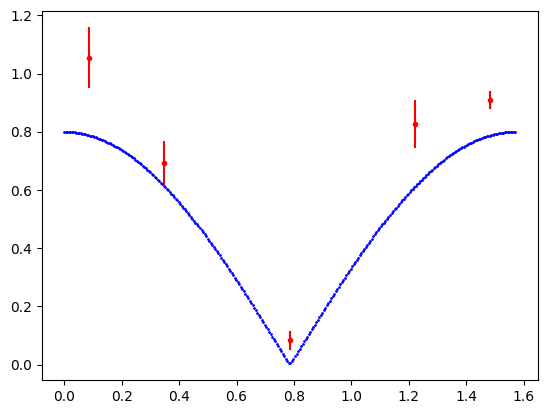

In [15]:
th = np.linspace(0, pi/2, 300,endpoint=True)
C = (1-p)*np.abs(np.cos(2*th))

#plt.plot(ts,C_AB,'r-')
plt.errorbar(ts, C_AB, dC_AB, fmt = 'r.')
plt.plot(th,C,'b.', markersize=2)

In [9]:
print(ts)
print(C_AB)
print(dC_AB)

[0.08726646259971647, 0.3490658503988659, 0.7853981633974483, 1.2217304763960306, 1.4835298641951802]
[1.0422832900404022, 0.6972917599284133, 0.0471508877834528, 0.6450280284498788, 0.8001844307251054]
[0.040590853442475025, 0.05306748530220275, 0.036702415449485805, 0.06214032602317979, 0.047676357833178494]
